The goal of this notebook is to try and find n-grams that will be useful features in terms of detecting genre.

In [2]:
# importing basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import copy
import json
from collections import Counter, deque

# read in the data set
df = pd.read_csv('../data/chordonomicon.csv', low_memory=False)

In [3]:
# Read the mapping CSV file
chord_relations = pd.read_csv('../data/chords_mapping.csv')

# Create a dictionary with keys the "chords" and values the "degrees"
chord_degrees = dict(zip(chord_relations['Chords'], chord_relations['Degrees']))
for key, value in chord_degrees.items():
    chord_degrees[key] = ast.literal_eval(value)
    
# full list of chords from the chords_mapping csv
known_chords = list(chord_degrees.keys())

In [4]:
# read the equivalence dictionary file
# this is a dictionary of dictionaries
#    the top-level keys are chord names (e.g. 'C','Amin')
#    the top-level values are dictionaries, whose keys are equivalent chords, and whose values are the semitone distance between the top-level key and the low-level key
with open('../data/harmonic_equivalence.json') as file:
    equiv_dict = json.load(file)

In [5]:
equiv_dict['C']

{'C': 0,
 'Cs': 1,
 'D': 2,
 'Ds': 3,
 'E': 4,
 'Es': 5,
 'Fs': 6,
 'G': 7,
 'Gs': 8,
 'A': 9,
 'As': 10,
 'B': 11,
 'Db': 1,
 'Eb': 3,
 'F': 5,
 'Gb': 6,
 'Ab': 8,
 'Bb': 10}

In [6]:
# drop all columns except for chords and genres
chord_data = df[['chords','genres']]

# drop anything that lacks chord or genre data
chord_data = chord_data.dropna()

In [7]:
# replacing spaces with commas
def replace_space_with_comma(my_string):
    return my_string.replace(" ",",")

In [8]:
# Remove section markers
def remove_section_markers(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '<':
            # Skip until after the following ", "
            j = my_string.find('>', i)
            if j == -1:
                break  # no closing '>', stop
            i = j + 2  # skip '>,' and the space
        else:
            result.append(my_string[i])
            i += 1
    assert('<' not in result)
    assert('>' not in result)
    return ''.join(result)

In [9]:
# Remove inversions
def remove_inversions(my_string):
    result = []
    i = 0
    n = len(my_string)
    while i < n:
        if my_string[i] == '/':
            # Skip until after the following ", "
            j = my_string.find(',', i)
            if j == -1:
                break  # no closing comma, stop
            i = j  # skip comma
        else:
            result.append(my_string[i])
            i += 1
    return ''.join(result)

In [10]:
def clean_up_chord_string(my_string):
    return remove_inversions(
        remove_section_markers(
            replace_space_with_comma(my_string)))

In [11]:
# cleaning up the data in a few ways
chord_data.loc[:,'chords'] = chord_data['chords'].apply(clean_up_chord_string)

In [12]:
chord_data.sample(5)

,chords,genres
364508,"Dmin,Amin,C,G,Dmin,Amin,C,G,Dno3d,Gno3d,Cno3d,...","alternative pop""boston rock""melancholia""rhode ..."
550166,"B,D,G,D,A,D,G,D,A,D,G,D,A,D,G,D,A,G,D,Emin,A,G...","austin americana""classic texas country"
334368,"A,E,B,Csmin,A,E,B,A,E,B,Csmin,A,E,B,A,E,B,E,A,...",modern country rock
196140,"A,C,A,D,A,D,A,C,D,G,D,A,C,D,G,D,A,C,D,G,D,A,D,...","alternative metal""alternative rock""grunge""perm..."
530102,"F,G,C,G,C,G,C,F,G,C,G,C,F,C,G,C,F,C,G,C,G,F,G,...","folk""new americana""roots rock""singer-songwriter"


In [13]:
# simplify genre data
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic']
def simplify_genre(genre_string):
    for g in major_genres:
        if g in genre_string:
            return g
    return 'other'

chord_data.loc[:,'genres'] = chord_data['genres'].apply(simplify_genre)
major_genres = ['pop','rock','country','alternative','punk','metal','rap','soul','jazz','reggae','electronic','other']

In [14]:
full_data_genre_counter = Counter(chord_data.genres)
full_data_genre_counter

Counter({'pop': 131247,
         'other': 106961,
         'rock': 81276,
         'country': 15884,
         'punk': 10060,
         'alternative': 4358,
         'rap': 4013,
         'metal': 3007,
         'soul': 2909,
         'reggae': 2156,
         'jazz': 1857,
         'electronic': 545})

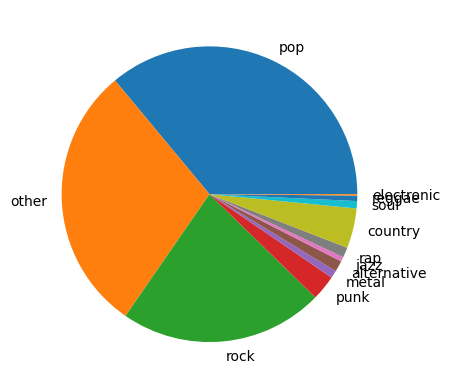

In [15]:
plt.pie(x = list(full_data_genre_counter.values()), 
        labels = list(full_data_genre_counter.keys()))
plt.show()

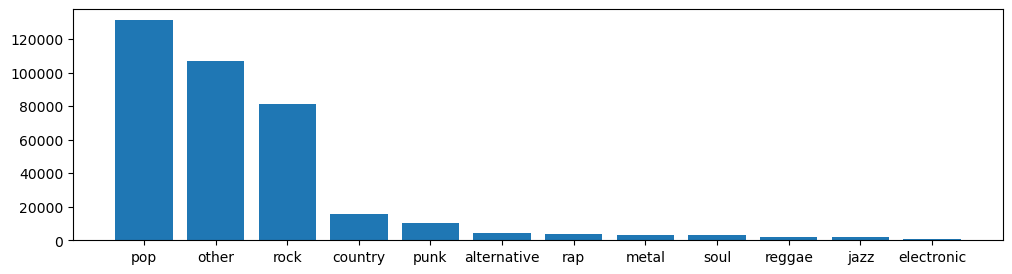

In [16]:
plt.figure(figsize=(12,3))
labels, values = zip(*full_data_genre_counter.most_common())
plt.bar(x = labels, 
        height = values)
plt.show()

In [17]:
# if the two input chords are harmonically equivalent, return (True, num_semitones) where num_semitones is the distance from n_gram_1 (up) to n_gram_2
# otherwise, return (False, None)
def compare_chords(chord_1, chord_2):
    if chord_2 in equiv_dict[chord_1]:
        return (True, equiv_dict[chord_1][chord_2])
    else:
        return (False, None)

print(compare_chords('C','D'))
print(compare_chords('C','E'))
print(compare_chords('C','Amin'))

(True, 2)
(True, 4)
(False, None)


In [18]:
# if the two input n_grams are harmonically equivalent, return (True, num_semitones) where num_semitones is the distance from n_gram_1 (up) to n_gram_2
# otherwise, return (False, None)
def compare_n_grams(n_gram_1, n_gram_2):
    list_1 = n_gram_1.split(',')
    list_2 = n_gram_2.split(',')

    # if they aren't the same length, we don't have to check anything
    if len(list_1) != len(list_2):
        return (False, None)

    # now we can assume they have the same length
    comparison = [compare_chords(list_1[i], list_2[i]) for i in range(len(list_1))]

    # if any pairs are not the same, return False
    for c in comparison:
        if not c[0]:
            return (False, None)

    # now we can assume every respective pair is equivalent, but we still need all of the distances to match
    dist_0 = comparison[0][1]
    for c in comparison:
        if c[1] != dist_0:
            return (False, None)

    return (True, dist_0)

print(compare_n_grams('C,D,E','F,G,A'))
print(compare_n_grams('C,D,E','F,G,B'))

(True, 5)
(False, None)


In [19]:
# return true/false depending on if a song contains a harmonically equivalent n_gram to the input n_gram
# new version of this, making use of the equivalence dictionary for lookups rather than doing calculations every time
def contains_n_gram(song, n_gram):
    # assumption: input song is a comma-separated string of chord names
    # assumption: input n_gram is a comma-separated string of chord names

    # skip ahead and return true if the raw version is the song
    if n_gram in song:
        return True

    # split up the song and n_gram into lists of strings of single chords
    song_as_list = song.split(',')
    song_length = len(song_as_list)
    n_gram_as_list = n_gram.split(',')
    n = len(n_gram_as_list)

    for i in range(0,song_length - n):
        song_n_gram = ','.join(song_as_list[i:i+n])
        is_same, dist = compare_n_grams(n_gram, song_n_gram)
        if is_same:
            return True

    return False

assert(contains_n_gram('A,B,C,D,E,F,G','C,D'))
assert(contains_n_gram('A,B,C,D,E,F','F,G'))

In [20]:
def get_raw_n_grams_list(data, n):
    # return a list of all raw n-grams, ignoring harmonic equivalence
    results = []
    for song in list(data.chords):
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            if not n_gram in results:
                results.append(n_gram)
    return results

In [21]:
def n_gram_belongs_to_list(list_of_n_grams, n_gram):
    for ng in list_of_n_grams:
        if compare_n_grams(ng,n_gram)[0]:
            return False
    return True

In [22]:
# return a list of harmonically unique n-grams
def get_unique_n_grams_list(data, n):
    results = []
    for song in list(data.chords):
        song_as_list = song.split(',')
        for i in range(len(song_as_list)-n+1):
            n_gram = ','.join(song_as_list[i:i+n])
            if n_gram_belongs_to_list(results,n_gram):
                results.append(n_gram)    
    return results

In [23]:
chord_data.sample(5)

,chords,genres
192649,"Bb,Gmin,Bb,Gmin,Bb,Gmin,Bb,Gmin,Bb,Gmin,Bb,Gmi...",pop
106808,"Bmin,A,G,Fsmin,Bmin,A,G,Fsmin,Bmin,Fsmin,D,Fsm...",other
574847,"D,A,A7,G,D,A,A7,G,D,A,A7,G,D,A,A7,G,D,A,A7,G,D...",rock
312436,"A,D,Aadd9,E,A,D,Aadd9,A,D,Aadd9,E,A,D,Aadd9,E,...",rock
232723,"E,A,B,E,A,B,Gsmin,Fsmin,Gsmin,Csmin,Gsmin,Fsmi...",rock


In [24]:
sample_data = chord_data.sample(5)
for c,g in zip(sample_data.chords,sample_data.genres):
    print(c)
    print(g)
    print()

C,Dmin,Gmin,F,C,Dmin,Gmin,F,C,Amin,G,Dmin,F,G,Amin,G,Dmin,F,G,Amin,Bb,F,C,Amin,Bb,F,Dmin,C,Bb,F,Amin,C,Bb,F,Amin,C,Amin,G,Dmin,F,G,Amin,G,Dmin,F,G,Amin
pop

Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Cs,B,Fs,Cs,Cs,B,Fs,Cs,Cs,B,Fs,Cs,Cs,B,Fs,Cs,Cs,B,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,Fs,Cs,E,A,Fs,Cs,E,B,Fs7,Cs,E,A,Fs,Cs,E,B,Fs7,Cs,E,A,Fs,Cs,E,B,Fs7,Cs,Cs,B,Fs
punk

C,B7,Bb7,A,Gs,G,C,E,Amin,F,G,C,E,Amin,F,G,A,Fsmin,Bmin,Fsmin,Bmin,Csmin,Fsmin,D,E,G
pop

C,F,G,F,G,C,F,G,F,G,C,F,G,F,G,C,F,G,F,G,C,F,G,F,G,C,F,C,F,C,G,C,F,C,G,C,F,C,F,C,G,C,F,C,G,C,F,G,F,G,C,F,G,F,G,C,F,C,F,C,G,C,F,C,G,C,F,C,F,C,G,C,F,C,G,C,F,G,F,G,C
other

C,G,C,F,C,G,C,F,C,D,G,F,C,G,F,G,C,F,C,G,C,F,C,D,G,F,C,F,G,C,F,C,G,C,A,D7,G7,G,C,F,C,D,G,F,C,C7,F,G,C,F,C
rock



In [25]:
def build_raw_counts_df(data, n_range):
    # construct a list of all unique n_grams that are present in the data, and n ranges over a specified list
    # these will be the rows of the dataframe
    n_grams = ['baseline']
    for n in n_range:
        n_grams += get_unique_n_grams_list(data, n)
    num_rows = len(n_grams)
    results_dict = {'n_gram' : n_grams}

    # initialize a bunch of columns of zeros, one for each major genre
    for g in major_genres:
        results_dict[g + '_raw'] = np.zeros(shape = num_rows, dtype = int)

    # compute the baseline row by just counting all genres
    for song, genre in zip(data.chords,data.genres):
        results_dict[genre + '_raw'][0] += 1
    
    # iterate over each n-gram, counting the number of songs of each genre that it appears in    
    for i in range(1, num_rows):
        ng = n_grams[i]
        for song, genre in zip(data.chords,data.genres):
            if contains_n_gram(song, ng):
                results_dict[genre + '_raw'][i] += 1

    results_df = pd.DataFrame(results_dict)
    
    # make a total counts column
    raw_columns = [g + '_raw' for g in major_genres]
    results_df['total'] = results_df[raw_columns].sum(axis=1)

    return results_df

sample_data = chord_data.sample(20)
build_raw_counts_df(sample_data, [1,2])

,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,reggae_raw,electronic_raw,other_raw,total
0,baseline,11,3,2,0,0,1,0,0,0,0,0,3,20
1,G,11,3,2,0,0,1,0,0,0,0,0,3,20
2,Amin,10,2,2,0,0,1,0,0,0,0,0,2,17
3,G7,3,0,0,0,0,0,0,0,0,0,0,1,4
4,Fmin7,1,0,1,0,0,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,"D,B7",1,0,0,0,0,0,0,0,0,0,0,0,1
70,"A,As",0,1,0,0,0,0,0,0,0,0,0,0,1
71,"Fmaj7,C",0,0,1,0,0,0,0,0,0,0,0,0,1
72,"C,Fmaj7",0,0,1,0,0,0,0,0,0,0,0,0,1


In [26]:
def add_relative_columns(raw_count_df):
    # input: a dataframe that has one row for each n-gram, with raw counts of genres it appears in
    # output: a new dataframe which is the same, but has added columns with relative counts
    results_df = copy.deepcopy(raw_count_df)
    for g in major_genres:
        results_df[g + '_rel'] = results_df[g + '_raw'] / results_df['total']
    return results_df

sample_data = chord_data.sample(20)
raw_df = build_raw_counts_df(sample_data, [1,2])
relative_df = add_relative_columns(raw_df)
display(relative_df)

,n_gram,pop_raw,rock_raw,country_raw,alternative_raw,punk_raw,metal_raw,rap_raw,soul_raw,jazz_raw,...,country_rel,alternative_rel,punk_rel,metal_rel,rap_rel,soul_rel,jazz_rel,reggae_rel,electronic_rel,other_rel
0,baseline,5,7,0,1,0,0,0,0,0,...,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350000
1,C,5,7,0,1,0,0,0,0,0,...,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.350000
2,Amin,4,7,0,1,0,0,0,0,0,...,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368421
3,Emaj7,0,2,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
4,Dsus2,0,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
5,A7,1,0,0,1,0,0,0,0,0,...,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000
6,Emin7,1,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,"C,Amin",3,2,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375000
8,"Amin,F",1,2,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000
9,"F,C",3,6,0,1,0,0,0,0,0,...,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.375000


In [36]:
def add_deviation_columns(relative_df, epsilon = 1e-12):
    # input: a dataframe that has one row for each n-gram, and two columns for each genre: a raw count, and relative count
    #          there should also be a first row for "baseline"
    #          there should also be a column for "total" which is the sume of the raw count columns in that row
    # output: a new dataframe which has added columns with some interesting metrics for deviation from baseline
    results_df = copy.deepcopy(relative_df)

    # metrics: 
    #     GENRE_dev_ratio - the ratio between the relative frequency of a genre among songs containing a given n-gram, and relative frequency of a genre as a baseline (among all songs in the sample)
    #                     - if this is 1, then the n-gram is not deviating from baseline relative frequencies
    #                     - farther from 1, it is more deviated
    #     GENRE_log_dev_ratio - the log of the previous metric, so that now zero represents being the same as baseline relative frequency, and 
    #                         - positive numbers indicate higher than baseline frequency, and negative numbers indicate lower than baseline frequency
    #     GENRE_abs_log_dev_ratio - the absolute value of the previous metric, so now bigger numbers represent higher deviation from baseline frequency
    
    for g in major_genres:
        dev_ratio = results_df[g + '_rel'] / results_df[g + '_rel'].iloc[0]
        #log_dev_ratio = np.where(dev_ratio != 0, np.log(dev_ratio), np.nan)
        
        results_df[g + '_dev_ratio'] = dev_ratio
        #results_df[g + '_log_dev_ratio'] = log_dev_ratio
        results_df[g + '_log_dev_ratio'] = np.log(dev_ratio.replace(0,np.nan))
        results_df[g + '_abs_log_dev_ratio'] = results_df[g + '_log_dev_ratio'].abs()

    # make a max_abs_log_dev_ratio column
    # and a mean_abs_log_dev_ratio column
    abs_log_dev_columns = [g + '_abs_log_dev_ratio' for g in major_genres]
    results_df['max_abs_log_dev_ratio'] = results_df[abs_log_dev_columns].max(axis=1)
    results_df['mean_abs_log_dev_ratio'] = results_df[abs_log_dev_columns].mean(axis=1)
    
    return results_df

sample_data = chord_data.sample(20)
raw_df = build_raw_counts_df(sample_data, [1,2])
relative_df = add_relative_columns(raw_df)
deviation_df = add_deviation_columns(relative_df)

pop_columns = ['n_gram', 'total', 'pop_raw', 'pop_rel', 'pop_dev_ratio', 'pop_log_dev_ratio', 'pop_abs_log_dev_ratio','max_abs_log_dev_ratio','mean_abs_log_dev_ratio']
display(deviation_df[pop_columns])

,n_gram,total,pop_raw,pop_rel,pop_dev_ratio,pop_log_dev_ratio,pop_abs_log_dev_ratio,max_abs_log_dev_ratio,mean_abs_log_dev_ratio
0,baseline,20,9,0.450000,1.000000,0.000000,0.000000,0.000000,0.000000
1,C,19,8,0.421053,0.935673,-0.066490,0.066490,0.066490,0.055092
2,Emin,19,9,0.473684,1.052632,0.051293,0.051293,0.051293,0.051293
3,Emin7,5,1,0.200000,0.444444,-0.810930,0.810930,0.810930,0.597253
4,Dmaj7,2,0,0.000000,0.000000,NaN,NaN,0.916291,0.713558
...,...,...,...,...,...,...,...,...,...
93,"Dmin7,D7",1,0,0.000000,0.000000,NaN,NaN,1.609438,1.609438
94,"Bb,E7",1,0,0.000000,0.000000,NaN,NaN,1.609438,1.609438
95,"Dmin,Bmin",1,0,0.000000,0.000000,NaN,NaN,1.609438,1.609438
96,"Bmin,Bb",1,0,0.000000,0.000000,NaN,NaN,1.609438,1.609438


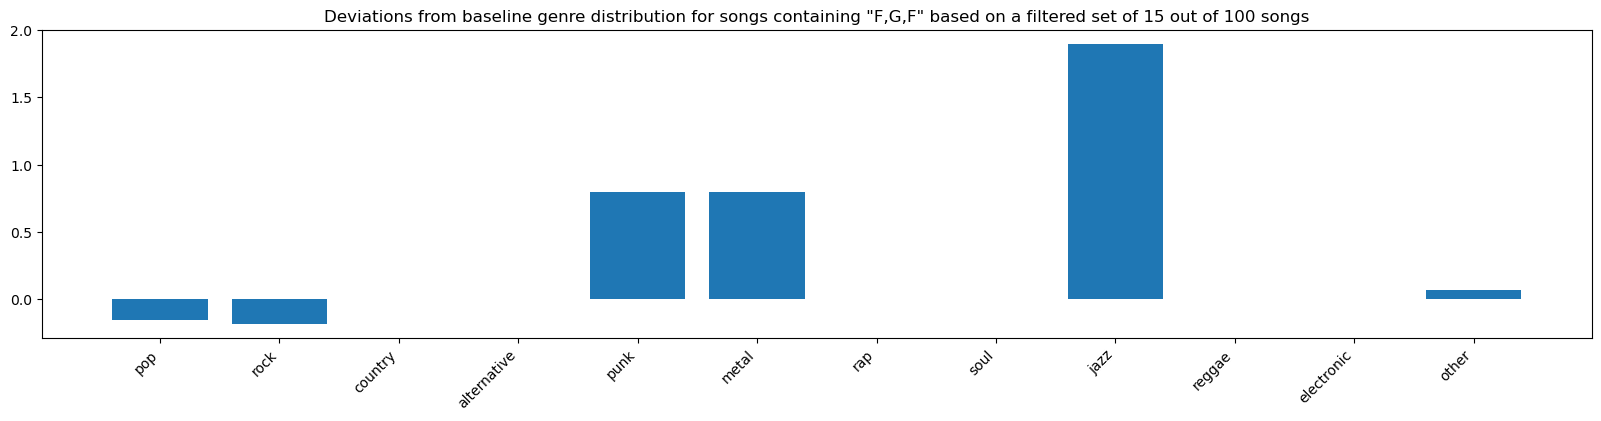

In [83]:
def plot_high_deviation_n_grams(deviation_df, sample_size_threshold = 0.1, top_fraction=0.1):
    # input: a dataframe with one row for a baseline, and one row per n_gram
    #        columns include n_gram, GENRE_abs_log_dev_ratio (for each major genre)
    # output: bar plots of the top fraction of n_grams, ranked by abs_log_dev_ratio
    df = copy.deepcopy(deviation_df)

    # drop all rows where the 'total' column doesn't meet the sample size threshold, which is sample_size_threshold times the baseline total value
    baseline_row_index = df.index[df['n_gram'] == 'baseline'][0]
    baseline_total = df.loc[baseline_row_index,'total']
    df = df[df.total >= baseline_total * sample_size_threshold]

    # sort by max_abs_log_dev_ratio, descending so the big ones are at the top. Get those top rows.
    df = df.sort_values(by = 'max_abs_log_dev_ratio', ascending = False)
    num_rows = len(df.index)
    num_top_rows = int(num_rows * top_fraction)
    top_rows = df.head(num_top_rows)

    for i in range(num_top_rows):
        row_i = df.iloc[i]
        height_data = [row_i[g + '_log_dev_ratio'] for g in major_genres]
        my_x = np.arange(len(major_genres))
        plt.figure(figsize = (20, 4))
        plt.bar(x = my_x,
                height = height_data)
        plt.xticks(my_x, major_genres, rotation = 45, ha = 'right')
        plt.title('Deviations from baseline genre distribution for songs containing "' + row_i['n_gram'] + '" based on a filtered set of ' + str(row_i['total']) + ' out of ' + str(baseline_total) + ' songs')
        plt.show()

sample_data = chord_data.sample(100)
raw_df = build_raw_counts_df(sample_data, [1,2,3])
relative_df = add_relative_columns(raw_df)
deviation_df = add_deviation_columns(relative_df)
plot_high_deviation_n_grams(deviation_df, sample_size_threshold = 0.15, top_fraction = 0.05)